In [81]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time

In [82]:
ASSET_CLASS_ETFS = {
    'Equities': ['SPY', 'QQQ', 'IWM', 'EFA'],
    'Rates': ['TLT', 'IEF', 'SHY'],
    'Commodities': ['GLD', 'USO', 'DBA'],
    'FX': ['FXE', 'FXY', 'FXB']
}

# SECTOR ETFs - For sector rotation and relative value analysis

SECTOR_ETFS = {
    'Technology': 'XLK',
    'Financials': 'XLF',
    'Healthcare': 'XLV',
    'Energy': 'XLE',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU',
    'Communication Services': 'XLC'
}

# SECTOR REPRESENTATIVE STOCKS - Individual stocks for sector analysis

SECTOR_LEADERS = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META'],
    'Financials': ['JPM', 'BAC', 'WFC', 'GS', 'MS'],
    'Healthcare': ['UNH', 'JNJ', 'LLY', 'ABBV', 'MRK'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'EOG'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE'],
    'Consumer Staples': ['WMT', 'PG', 'KO', 'PEP', 'COST'],
    'Industrials': ['BA', 'CAT', 'HON', 'UNP', 'GE'],
    'Materials': ['LIN', 'APD', 'SHW', 'NEM', 'FCX'],
    'Real Estate': ['PLD', 'AMT', 'SPG', 'EQIX', 'PSA'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP'],
    'Communication Services': ['GOOGL', 'META', 'DIS', 'NFLX', 'CMCSA']
}

# RECOMMENDED UNIVERSES FOR DIFFERENT ANALYSES

MINIMAL_CROSS_ASSET = (
    ASSET_CLASS_ETFS['Equities'] + 
    ASSET_CLASS_ETFS['Rates'] + 
    ASSET_CLASS_ETFS['Commodities'] + 
    ASSET_CLASS_ETFS['FX']
)

# Universe 2: Cross-asset + sectors (24 assets, 276 pairs)
CROSS_ASSET_WITH_SECTORS = MINIMAL_CROSS_ASSET + list(SECTOR_ETFS.values())

In [83]:
all_tickers = CROSS_ASSET_WITH_SECTORS
data = yf.download(all_tickers, start="2020-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    prices = data['Close']
else:
    prices = data[['Close']]
    prices.columns = all_tickers
print(prices.head())

# Calculate returns
returns = prices.pct_change().dropna()

# Make sure we only have tickers
assert all(col in all_tickers for col in returns.columns), "ERROR: Non-ticker columns found!"
assert 'Close' not in returns.columns, "ERROR: 'Close' still in columns!"
assert 'High' not in returns.columns, "ERROR: 'High' still in columns!"
assert 'Volume' not in returns.columns, "ERROR: 'Volume' still in columns!"

[*********************100%***********************]  24 of 24 completed

Ticker            DBA        EFA         FXB         FXE        FXY  \
Date                                                                  
2020-01-02  14.560221  58.637081  117.031311  100.962280  87.510002   
2020-01-03  14.392557  57.909763  116.415855  100.905090  87.919998   
2020-01-06  14.427855  58.135479  117.279343  101.162613  87.650002   
2020-01-07  14.463151  57.976639  116.856758  100.723824  87.510002   
2020-01-08  14.392557  58.143852  116.663887  100.428169  87.099998   

Ticker             GLD        IEF         IWM         QQQ        SHY  ...  \
Date                                                                  ...   
2020-01-02  143.949997  96.231735  153.706024  208.580246  74.180779  ...   
2020-01-03  145.860001  96.874870  153.103348  206.669662  74.242111  ...   
2020-01-06  147.389999  96.770546  153.307388  208.001266  74.215813  ...   
2020-01-07  147.970001  96.631508  152.797409  207.972305  74.215813  ...   
2020-01-08  146.860001  96.405525  153.2

In [84]:
# Rolling correlation with lookback windows
short_window = 30
long_window = 252 # 252 trading days in a year
rolling_corr = returns.rolling(window=short_window).corr()
historical_corr = returns.rolling(window=long_window).corr()

In [85]:
# current vs historical correlation heatmap
def plot_correlation_comparison(returns, short_window, long_window):
    current_corr = returns.tail(short_window).corr()
    historical_corr = returns.corr()
    diff_corr = current_corr - historical_corr
    fig, axes = plt.subplots(1,3, figsize=(20,6))

    # Plot 1: Current correlations
    sns.heatmap(current_corr, annot=True, fmt=".2f", cmap="RdYlGn", 
               center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={"label" : "Correlation"})
    axes[0].set_title(f'Current Correlation (Last {short_window} Days)', fontsize=14, fontweight="bold")
    
    # Plot 2: Historical correlations
    sns.heatmap(historical_corr, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Historical Correlation (Full Period)', fontsize=14, fontweight='bold')
    
    # Plot 3: Difference (dislocations)
    sns.heatmap(diff_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Difference'})
    axes[2].set_title('Dislocation (Current - Historical)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return current_corr, historical_corr, diff_corr

# 2. STATISTICAL ALERTS - FLAG REGIME BREAKS
def detect_dislocations(returns, short_window=30, long_window=252, threshold=2):
    """Identify correlation pairs that have broken from historical norms"""
    
    # Calculate rolling correlation for each pair
    all_pairs = []
    
    for i, ticker1 in enumerate(returns.columns):
        for ticker2 in returns.columns[i+1:]:
            # Rolling correlation
            rolling_corr = returns[ticker1].rolling(long_window).corr(returns[ticker2])
            
            # Historical mean and std
            hist_mean = rolling_corr.mean()
            hist_std = rolling_corr.std()
            
            # Current correlation
            current_corr = returns[ticker1].tail(short_window).corr(returns[ticker2])
            
            # Z-score
            z_score = (current_corr - hist_mean) / hist_std if hist_std != 0 else 0
            
            # Store results
            all_pairs.append({
                'Pair': f'{ticker1} vs {ticker2}',
                'Current': current_corr,
                'Historical Mean': hist_mean,
                'Historical Std': hist_std,
                'Z-Score': z_score,
                'Alert': 'YES' if abs(z_score) > threshold else 'NO',
                'Direction': 'STRONGER' if z_score > 0 else 'WEAKER'
            })
    
    df_alerts = pd.DataFrame(all_pairs)
    df_alerts = df_alerts.sort_values('Z-Score', key=abs, ascending=False)
    
    return df_alerts

In [86]:
# 3. TIME SERIES OF KEY CORRELATIONS
def plot_key_correlations(returns, pairs, window=60):
    """Plot how specific correlations evolve over time"""
    
    fig, axes = plt.subplots(len(pairs), 1, figsize=(14, 4*len(pairs)))
    if len(pairs) == 1:
        axes = [axes]
    
    for idx, (ticker1, ticker2) in enumerate(pairs):
        # Rolling correlation
        rolling_corr = returns[ticker1].rolling(window).corr(returns[ticker2])
        
        # Historical mean and std bands
        hist_mean = rolling_corr.mean()
        hist_std = rolling_corr.std()
        
        # Plot
        ax = axes[idx]
        ax.plot(rolling_corr.index, rolling_corr, label='Rolling Correlation', linewidth=2)
        ax.axhline(hist_mean, color='black', linestyle='--', label='Historical Mean', linewidth=1.5)
        ax.axhline(hist_mean + 2*hist_std, color='red', linestyle=':', label='±2σ', linewidth=1)
        ax.axhline(hist_mean - 2*hist_std, color='red', linestyle=':', linewidth=1)
        ax.fill_between(rolling_corr.index, hist_mean - hist_std, hist_mean + hist_std, 
                         alpha=0.2, color='gray', label='±1σ Band')
        
        ax.set_title(f'{ticker1} vs {ticker2} - Rolling {window}d Correlation', fontsize=12, fontweight='bold')
        ax.set_ylabel('Correlation')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Finding top correlations

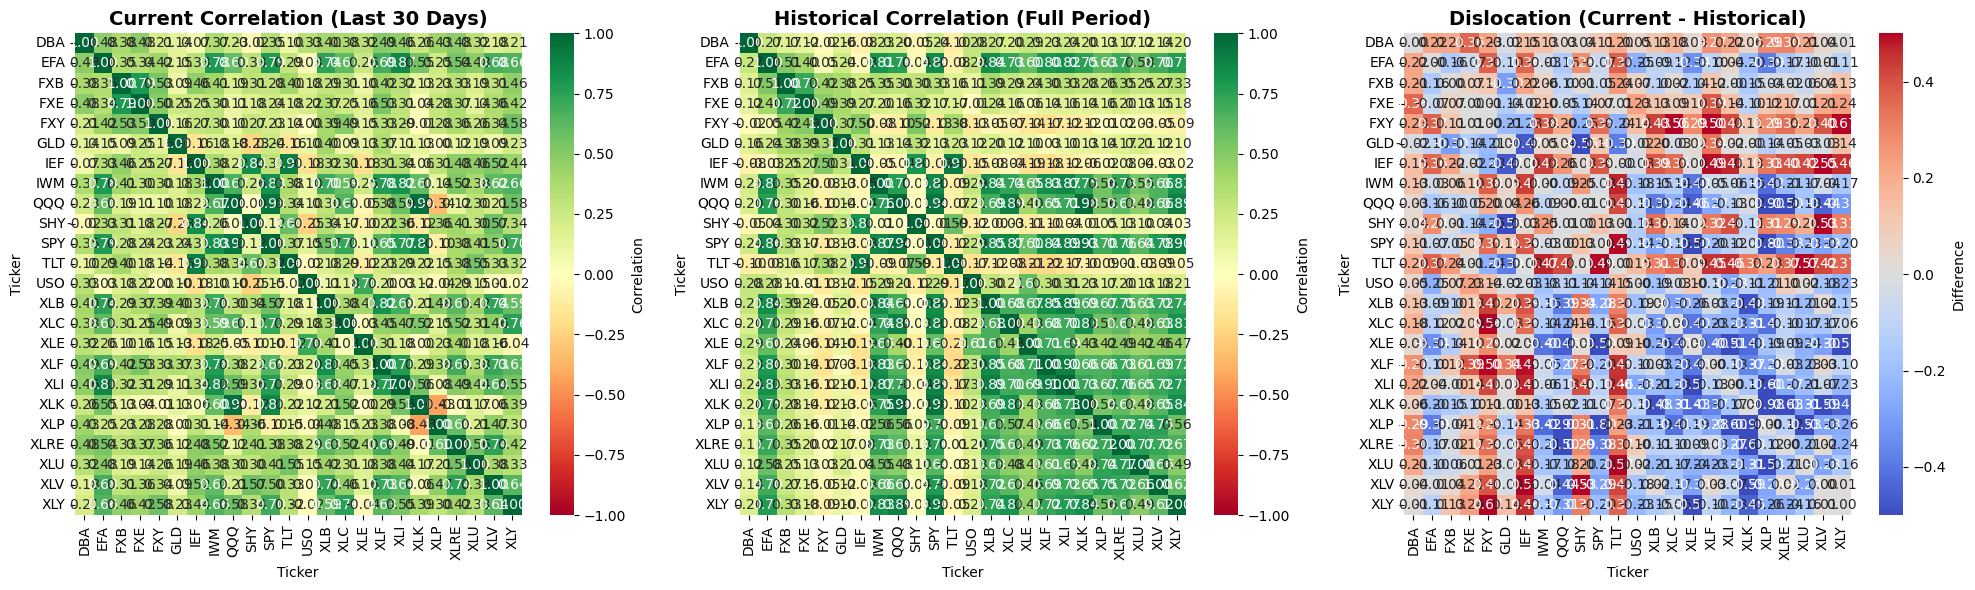


Top 20 Correlation Changes (by |Z-Score|):
       Pair   Current  Historical Mean  Historical Std   Z-Score Alert Direction
 QQQ vs XLY  0.576743         0.865073        0.047250 -6.102254   YES    WEAKER
 XLK vs XLY  0.387728         0.796929        0.067262 -6.083724   YES    WEAKER
 SPY vs XLY  0.695471         0.877367        0.032648 -5.571433   YES    WEAKER
 XLP vs XLU  0.207962         0.631707        0.092461 -4.582961   YES    WEAKER
 DBA vs FXE  0.479880         0.135767        0.078977  4.357130   YES  STRONGER
 QQQ vs XLP -0.337857         0.411159        0.179473 -4.173415   YES    WEAKER
 SPY vs XLP -0.097517         0.573723        0.166424 -4.033313   YES    WEAKER
 GLD vs TLT -0.160761         0.256959        0.105911 -3.944053   YES    WEAKER
 SHY vs XLV  0.572741         0.112471        0.116709  3.943742   YES  STRONGER
 XLK vs XLP -0.434550         0.384801        0.215575 -3.800765   YES    WEAKER
DBA vs XLRE  0.478513         0.117402        0.095567  3.778618 

In [87]:
# Generate visualizations
current_corr, historical_corr, diff_corr = plot_correlation_comparison(returns, short_window = 30, long_window = 252)

# Detect dislocations
df_alerts = detect_dislocations(returns)

# Show top dislocations
print("\nTop 20 Correlation Changes (by |Z-Score|):")
print(df_alerts.head(20).to_string(index=False))

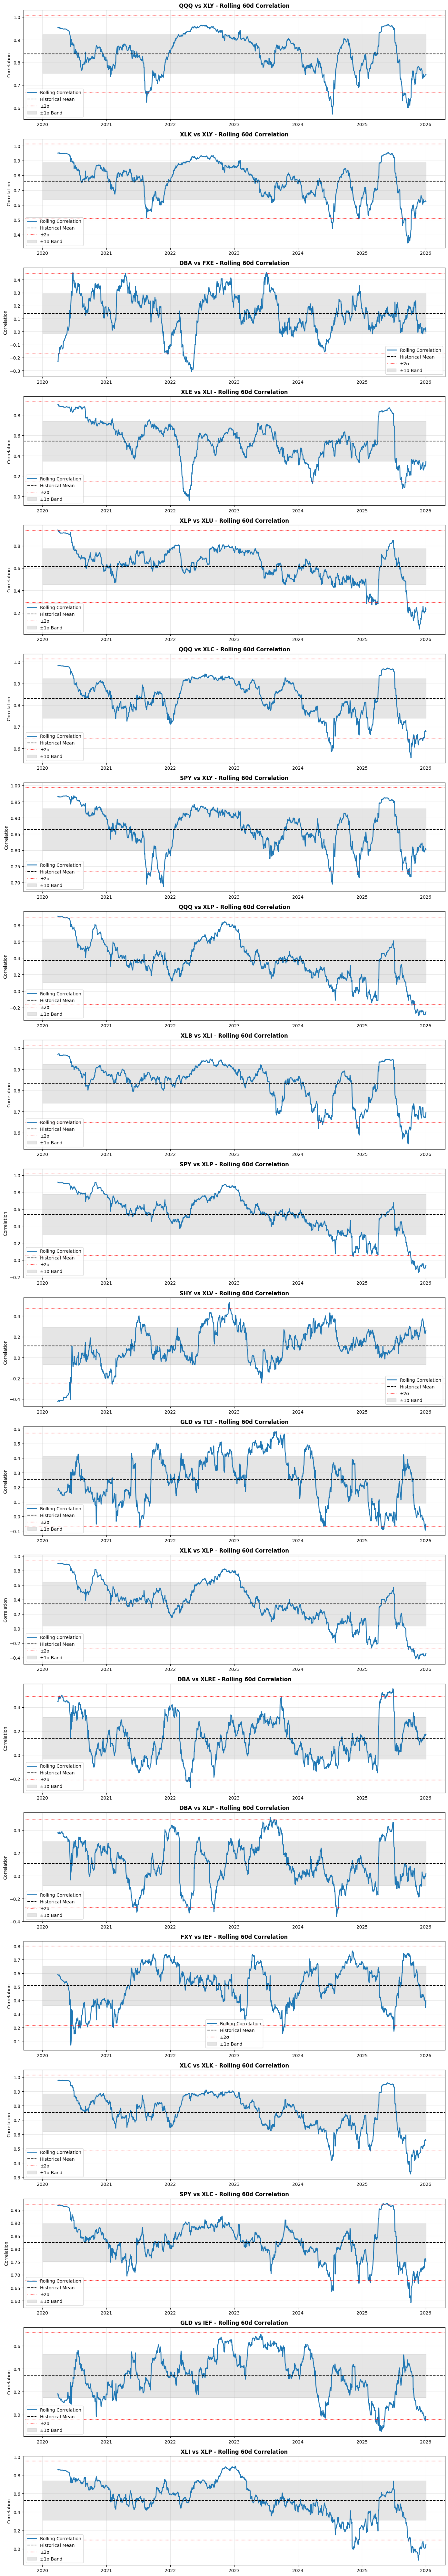

In [88]:
pairs = [
    ("QQQ", "XLY"),
    ("XLK", "XLY"),
    ("DBA", "FXE"),
    ("XLE", "XLI"),
    ("XLP", "XLU"),
    ("QQQ", "XLC"),
    ("SPY", "XLY"),
    ("QQQ", "XLP"),
    ("XLB", "XLI"),
    ("SPY", "XLP"),
    ("SHY", "XLV"),
    ("GLD", "TLT"),
    ("XLK", "XLP"),
    ("DBA", "XLRE"),
    ("DBA", "XLP"),
    ("FXY", "IEF"),
    ("XLC", "XLK"),
    ("SPY", "XLC"),
    ("GLD", "IEF"),
    ("XLI", "XLP"),
]

plot_key_correlations(returns, pairs, window=60)

When correlations break from expected patterns, such as the classic equity-bond hedge relationship deteriorating, it creates actionable trading opportunities through mean reversion or signals regime changes in market structure.

In [89]:
class CorrelationMeanReversionBacktest:
    """
    Backtest mean reversion trading strategy based on correlation z-scores.
    
    Strategy:
    - Enter pairs trade when |z-score| > entry_threshold
    - Exit when z-score returns to mean or hits stop loss
    - Position: Long underperformer, Short outperformer
    """
    
    def __init__(self, returns, lookback_window=252, short_window=30):
        """
        Initialize backtester
        
        Args:
            returns: DataFrame of asset returns
            lookback_window: Window for historical mean/std (default 252 days)
            short_window: Window for current correlation (default 30 days)
        """
        self.returns = returns
        self.lookback_window = lookback_window
        self.short_window = short_window
        self.trades = []
        self.equity_curve = None
        
    def calculate_rolling_zscores(self, asset1, asset2):
        
        rolling_corr = self.returns[asset1].rolling(self.short_window).corr(
            self.returns[asset2]
        )
        
        historical_mean = rolling_corr.rolling(self.lookback_window, min_periods=self.lookback_window).mean()
        historical_std = rolling_corr.rolling(self.lookback_window, min_periods=self.lookback_window).std()
        
        # Z-score
        z_score = (rolling_corr - historical_mean) / historical_std
        
        return z_score, rolling_corr, historical_mean, historical_std
    
    def backtest_pair(self, asset1, asset2, entry_threshold=2.0, exit_threshold=0.5, 
                      stop_loss_z=3.5, holding_period=20, position_size=0.01):
        z_scores, corr, mean, std = self.calculate_rolling_zscores(asset1, asset2)
        
        # Initialize tracking
        in_position = False
        entry_date = None
        entry_z = None
        entry_sign = None
        trades = []
        
        start_idx = self.lookback_window + self.short_window
        
        for i in range(start_idx, len(self.returns)):
            current_date = self.returns.index[i]
            current_z = z_scores.iloc[i]
            
            # Skip if z-score is NaN
            if pd.isna(current_z):
                continue
            
            # Entry logic
            if not in_position and abs(current_z) > entry_threshold:
                in_position = True
                entry_date = current_date
                entry_z = current_z
                entry_sign = np.sign(current_z)
                entry_idx = i
                
                # Determine long/short based on z-score direction
                # If z > 0: correlation stronger than usual
                # Mean reversion: expect correlation to weaken
                # Trade: depends on which asset outperformed
                
            # Exit logic
            elif in_position:
                days_held = (current_date - entry_date).days
                
                # Exit conditions
                exit_signal = False
                exit_reason = None
                
                # 1. Mean reversion: z-score returned to normal
                if abs(current_z) < exit_threshold:
                    exit_signal = True
                    exit_reason = "Mean Reversion"
                
                # 2. Stop loss: z-score exceeded threshold (regime change)
                elif abs(current_z) > stop_loss_z:
                    exit_signal = True
                    exit_reason = "Stop Loss (Regime Change)"
                
                # 3. Max holding period
                elif days_held >= holding_period:
                    exit_signal = True
                    exit_reason = "Max Holding Period"
                
                if exit_signal:
                    # Calculate P&L
                    # Simplified: equal-weighted long-short based on relative performance
                    asset1_ret = self.returns[asset1].iloc[entry_idx:i+1].sum()
                    asset2_ret = self.returns[asset2].iloc[entry_idx:i+1].sum()
                    
                    # If correlation was too high (z > 0), bet on divergence
                    # Long the underperformer, short the outperformer
                    if entry_sign > 0:
                        # Correlation too high, expect to weaken
                        if asset1_ret < asset2_ret:
                            pnl = asset1_ret - asset2_ret  # Long asset1, short asset2
                        else:
                            pnl = asset2_ret - asset1_ret  # Long asset2, short asset1
                    else:
                        # Correlation too low, expect to strengthen
                        if asset1_ret > asset2_ret:
                            pnl = asset1_ret + asset2_ret  # Both should move together
                        else:
                            pnl = -(abs(asset1_ret) + abs(asset2_ret))
                    
                    # Apply position sizing
                    pnl = pnl * position_size
                    
                    # Record trade
                    trades.append({
                        'Pair': f"{asset1}-{asset2}",
                        'Entry Date': entry_date,
                        'Exit Date': current_date,
                        'Days Held': days_held,
                        'Entry Z-Score': entry_z,
                        'Exit Z-Score': current_z,
                        'Exit Reason': exit_reason,
                        'P&L (%)': pnl * 100,  # Convert to percentage
                        'Profit': pnl > 0
                    })
                    
                    # Reset position
                    in_position = False
                    entry_date = None
                    entry_z = None
        
        return pd.DataFrame(trades)
    
    def backtest_all_pairs(self, pairs=None, entry_threshold=2.0, exit_threshold=0.5,
                          stop_loss_z=3.5, holding_period=20, position_size=0.01):
        """
        Backtest strategy across multiple pairs
        
        Args:
            pairs: List of tuples [(asset1, asset2), ...]. If None, test all pairs.
            entry_threshold: Z-score to enter
            exit_threshold: Z-score to exit (mean reversion)
            stop_loss_z: Z-score to exit (stop loss)
            holding_period: Max holding period
            position_size: Position size per trade
        
        Returns:
            DataFrame with all trades
        """
        
        if pairs is None:
            # Generate all pairs
            tickers = self.returns.columns.tolist()
            pairs = [(tickers[i], tickers[j]) 
                     for i in range(len(tickers)) 
                     for j in range(i+1, len(tickers))]
        
        print(f"Backtesting {len(pairs)} pairs...")
        
        all_trades = []
        
        for i, (asset1, asset2) in enumerate(pairs):
            if (i + 1) % 10 == 0:
                print(f"  Processed {i+1}/{len(pairs)} pairs...")
            
            try:
                pair_trades = self.backtest_pair(
                    asset1, asset2, 
                    entry_threshold=entry_threshold,
                    exit_threshold=exit_threshold,
                    stop_loss_z=stop_loss_z,
                    holding_period=holding_period,
                    position_size=position_size
                )
                
                if len(pair_trades) > 0:
                    all_trades.append(pair_trades)
                    
            except Exception as e:
                print(f"  Error with {asset1}-{asset2}: {e}")
                continue
        
        if len(all_trades) == 0:
            print("No trades generated!")
            return pd.DataFrame()
        
        # Combine all trades
        self.trades = pd.concat(all_trades, ignore_index=True)
        
        print(f"✓ Backtest complete: {len(self.trades)} trades generated")
        
        return self.trades
    
    def calculate_equity_curve(self):
        """Calculate equity curve from trades"""
        
        if len(self.trades) == 0:
            print("No trades to analyze!")
            return None
        
        # Sort trades by exit date
        trades_sorted = self.trades.sort_values('Exit Date').copy()
        
        # Calculate cumulative P&L
        trades_sorted['Cumulative P&L (%)'] = trades_sorted['P&L (%)'].cumsum()
        
        # Store equity curve
        self.equity_curve = trades_sorted[['Exit Date', 'Cumulative P&L (%)']].copy()
        
        return self.equity_curve
    
    def generate_performance_report(self):
        """Generate comprehensive performance metrics"""
        
        if len(self.trades) == 0:
            print("No trades to analyze!")
            return None
        
        # Basic metrics
        total_trades = len(self.trades)
        winning_trades = len(self.trades[self.trades['Profit'] == True])
        losing_trades = len(self.trades[self.trades['Profit'] == False])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # P&L metrics
        total_pnl = self.trades['P&L (%)'].sum()
        avg_win = self.trades[self.trades['Profit'] == True]['P&L (%)'].mean() if winning_trades > 0 else 0
        avg_loss = self.trades[self.trades['Profit'] == False]['P&L (%)'].mean() if losing_trades > 0 else 0
        
        # Risk metrics
        sharpe_ratio = self.trades['P&L (%)'].mean() / self.trades['P&L (%)'].std() if self.trades['P&L (%)'].std() > 0 else 0
        max_win = self.trades['P&L (%)'].max()
        max_loss = self.trades['P&L (%)'].min()
        
        # Holding period
        avg_holding_period = self.trades['Days Held'].mean()
        
        # Exit reason breakdown
        exit_reasons = self.trades['Exit Reason'].value_counts()
        
        # Create report
        report = {
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate * 100,
            'Total P&L (%)': total_pnl,
            'Average Win (%)': avg_win,
            'Average Loss (%)': avg_loss,
            'Profit Factor': abs(avg_win / avg_loss) if avg_loss != 0 else np.inf,
            'Sharpe Ratio (annualized)': sharpe_ratio * np.sqrt(252),
            'Max Win (%)': max_win,
            'Max Loss (%)': max_loss,
            'Avg Holding Period (days)': avg_holding_period,
        }
        
        return report, exit_reasons
    
    def plot_results(self):
        """Generate visualization of backtest results"""
        
        if len(self.trades) == 0:
            print("No trades to plot!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # 1. Equity curve
        equity = self.calculate_equity_curve()
        axes[0, 0].plot(equity['Exit Date'], equity['Cumulative P&L (%)'], linewidth=2)
        axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[0, 0].set_title('Cumulative P&L Over Time', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Cumulative P&L (%)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. P&L distribution
        axes[0, 1].hist(self.trades['P&L (%)'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[0, 1].set_title('P&L Distribution', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('P&L per Trade (%)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Win rate by entry z-score
        bins = [-np.inf, -3, -2.5, -2, 2, 2.5, 3, np.inf]
        labels = ['<-3', '-3 to -2.5', '-2.5 to -2', '-2 to 2', '2 to 2.5', '2.5 to 3', '>3']
        self.trades['Z-Score Bin'] = pd.cut(self.trades['Entry Z-Score'], bins=bins, labels=labels)
        
        win_rate_by_z = self.trades.groupby('Z-Score Bin')['Profit'].mean() * 100
        win_rate_by_z.plot(kind='bar', ax=axes[1, 0], color='steelblue', edgecolor='black')
        axes[1, 0].axhline(y=50, color='red', linestyle='--', linewidth=2)
        axes[1, 0].set_title('Win Rate by Entry Z-Score', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Entry Z-Score Range')
        axes[1, 0].set_ylabel('Win Rate (%)')
        axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Exit reason breakdown
        exit_reasons = self.trades['Exit Reason'].value_counts()
        colors = ['green' if 'Mean' in reason else 'red' if 'Stop' in reason else 'gray' 
                  for reason in exit_reasons.index]
        exit_reasons.plot(kind='bar', ax=axes[1, 1], color=colors, edgecolor='black')
        axes[1, 1].set_title('Exit Reason Breakdown', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Exit Reason')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_report(self):
        """Print formatted performance report"""
        
        report, exit_reasons = self.generate_performance_report()
        
        print("\n" + "="*70)
        print("BACKTEST PERFORMANCE REPORT")
        print("="*70)
        
        print("\n TRADE STATISTICS")
        print(f"  Total Trades: {report['Total Trades']}")
        print(f"  Winning Trades: {report['Winning Trades']}")
        print(f"  Losing Trades: {report['Losing Trades']}")
        print(f"  Win Rate: {report['Win Rate (%)']:.2f}%")
        
        print("\n P&L METRICS")
        print(f"  Total P&L: {report['Total P&L (%)']:.2f}%")
        print(f"  Average Win: {report['Average Win (%)']:.2f}%")
        print(f"  Average Loss: {report['Average Loss (%)']:.2f}%")
        print(f"  Profit Factor: {report['Profit Factor']:.2f}")
        
        print("\n RISK METRICS")
        print(f"  Sharpe Ratio (annualized): {report['Sharpe Ratio (annualized)']:.2f}")
        print(f"  Max Win: {report['Max Win (%)']:.2f}%")
        print(f"  Max Loss: {report['Max Loss (%)']:.2f}%")
        
        print("\n  TRADE DURATION")
        print(f"  Avg Holding Period: {report['Avg Holding Period (days)']:.1f} days")
    
        print("\n EXIT REASONS")
        for reason, count in exit_reasons.items():
            pct = (count / report['Total Trades']) * 100
            print(f"  {reason}: {count} ({pct:.1f}%)")
        
        print("\n" + "="*70)
        
        # Top performing pairs
        print("\n TOP 5 PERFORMING PAIRS")
        top_pairs = self.trades.groupby('Pair')['P&L (%)'].sum().sort_values(ascending=False).head(5)
        for pair, pnl in top_pairs.items():
            print(f"  {pair}: {pnl:.2f}%")
        
        print("\n" + "="*70)

In [90]:
backtest = CorrelationMeanReversionBacktest(returns)
key_pairs = [
        ('SPY', 'TLT'),  # Equity-bond
        ('SPY', 'GLD'),  # Equity-gold
        ('TLT', 'GLD'),  # Bond-gold
        ('QQQ', 'IWM'),  # Large vs small cap
        ('SPY', 'FXY'),  # Equity-yen
        ('GLD', 'DBA'),  # Gold-agriculture
 ]

In [91]:
trades = backtest.backtest_all_pairs(
        pairs=key_pairs,
        entry_threshold=2.0,      # Enter when |z| > 2.0
        exit_threshold=0.5,       # Exit when |z| < 0.5 (mean reversion)
        stop_loss_z=3.5,          # Stop loss if |z| > 3.5 (regime change)
        holding_period=20,        # Max 20 days
        position_size=0.02        # 2% per trade
    )

Backtesting 6 pairs...
✓ Backtest complete: 97 trades generated



BACKTEST PERFORMANCE REPORT

 TRADE STATISTICS
  Total Trades: 97
  Winning Trades: 26
  Losing Trades: 71
  Win Rate: 26.80%

 P&L METRICS
  Total P&L: -4.11%
  Average Win: 0.06%
  Average Loss: -0.08%
  Profit Factor: 0.75

 RISK METRICS
  Sharpe Ratio (annualized): -7.77
  Max Win: 0.18%
  Max Loss: -0.31%

  TRADE DURATION
  Avg Holding Period: 14.7 days

 EXIT REASONS
  Max Holding Period: 58 (59.8%)
  Stop Loss (Regime Change): 29 (29.9%)
  Mean Reversion: 10 (10.3%)


 TOP 5 PERFORMING PAIRS
  SPY-TLT: -0.34%
  SPY-GLD: -0.45%
  TLT-GLD: -0.51%
  SPY-FXY: -0.63%
  GLD-DBA: -0.64%



C:\Users\charles\AppData\Local\Temp\ipykernel_10124\1588405426.py:297: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_z = self.trades.groupby('Z-Score Bin')['Profit'].mean() * 100


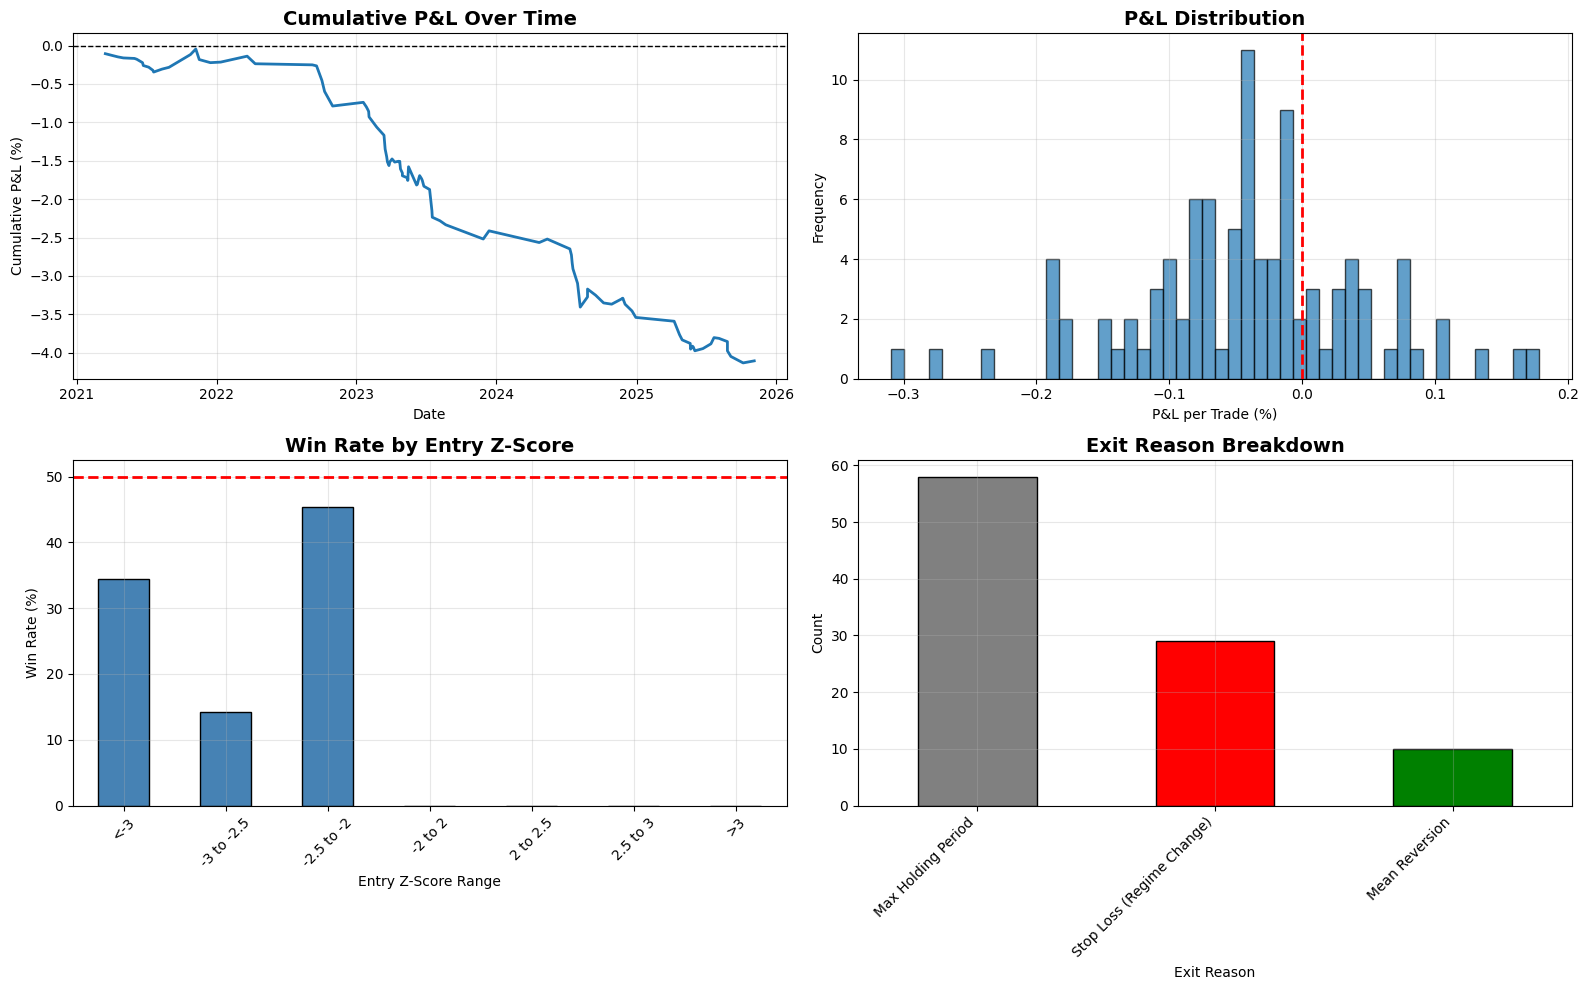

In [92]:
if len(trades) > 0:
        backtest.print_report()
        backtest.plot_results()
else:
        print("No trades generated. Try lowering entry_threshold or expanding date range.")

I initially hypothesized that correlation z-scores could generate mean-reversion trades. The backtest showed a 27% win rate and an overall loss of 4% with 60% of trades hitting max holding period, which is clear evidence that correlations don't revert in 20 days.
This taught me that cross-asset correlations are regime-dependent, not mean-reverting. A z-score of 2-3 isn't a trade signal, but rather it's a signal to rebalance the portfolio. When SPY-TLT correlation breaks down, you don't short the spread; you add alternative hedges like gold or volatility.
The real value is regime identification for portfolio construction, not tactical stat-arb. This is why macro desks use correlation analysis—not for pairs trading, but for understanding when diversification is working and when it's broken.